# Example 2: Acceleration due to gravity

To illustrate how to use $\verb|emulator|$ and $\verb|calibrator|$ objects, we will start with a very simple example of a falling ball.

First, import the main libraries we use for this example:

In [1]:
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
import scipy.stats as sps
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator
from base.calibration import calibrator

## Data: Falling ball

The data include 63 field observations at 21 heights, with three replicates at each height. Let's read the real data first, and then visualize:

In [2]:
# Read the data
ball = np.loadtxt('ball.csv', delimiter=',')
n = len(ball)
#height
X = np.reshape(ball[:, 0], (n, 1))
X = X[0:21]
#time
Y = np.reshape(ball[:, 1], ((n, 1)))
# This is a stochastic one but we convert it deterministic by taking the average height
Ysplit = np.split(Y, 3)
ysum = 0
for y in  Ysplit:
    ysum += y 
obsvar = np.maximum(0.2*X, 0.5)
Y = ysum/3

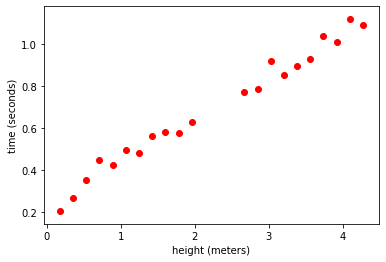

In [3]:
# Observe the data
plt.scatter(X, Y, color = 'red')
plt.xlabel("height (meters)")
plt.ylabel("time (seconds)")
plt.show()

## Computer model experiments

We know from Physics 101 that time $t$ to drop a distance $h$ for gravity $g$ is $t = \sqrt{2h/g}$. Consider the computer implementation that maps $(h, g)$ to $(x, \theta)$ in $[0, 1]$.

In [4]:
# Computer implementation of the mathematical model
def timedrop(x, theta, hr, gr):
    # Assume x and theta are within (0, 1)
    min_g = min(gr)
    range_g = max(gr) - min(gr)
    min_h = min(hr)
    range_h = max(hr) - min(hr)
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        g = range_g*theta[k] + min_g
        h = range_h*x + min(hr)
        f[k, :] = np.sqrt(2*h/g).reshape(x.shape[0])
    return f.T

Consider computer model emulator where $g \in [1, 30]$, and perform computer model simulations at 100 random locations.

In [5]:
# Draw 100 random parameters from uniform prior
n2 = 100
theta = np.random.random(n2).reshape((n2, 1))
theta_range = np.array([1, 30])

# Standardize 
height_range = np.array([min(X), max(X)])
X_std = (X - min(X))/(max(X) - min(X))

# Obtain computer model output
Y_model = timedrop(X_std, theta, height_range, theta_range)

print(np.shape(theta))
print(np.shape(X_std))
print(np.shape(Y_model))

(100, 1)
(21, 1)
(21, 100)


## Bayesian calibration of computer models

### Building an emulator 

Let's build an emulator for computer model runs:

In [6]:
emulator_1 = emulator(X_std, theta, Y_model, method = 'PCGPwM')

In [7]:
emulator_2 = emulator(X_std, theta, Y_model, method = 'PCGP_ozge', args = {'is_pca': True})

Function supplementtheta not found in module!
no of pcs: 2


### Building a calibrator

In [8]:
def plot_pred(X_std, Y, cal, theta_range):
    
    fig, axs = plt.subplots(1, 4, figsize=(14, 3))
    
    cal_theta = cal.theta.rnd(1000) 
    cal_theta = cal_theta*(theta_range[1] - theta_range[0]) + theta_range[0]  
    axs[0].plot(cal_theta)
    axs[1].boxplot(cal_theta)
    axs[2].hist(cal_theta)
    post = cal.predict(X_std)
    rndm_m = post.rnd(s = 1000)
    upper = np.percentile(rndm_m, 97.5, axis = 0)
    lower = np.percentile(rndm_m, 2.5, axis = 0)
    median = np.percentile(rndm_m, 50, axis = 0)
    #plt.xlabel("height (meters)")
    #plt.ylabel("time (seconds)")
    axs[3].plot(median, color = 'black')
    axs[3].fill_between(range(0, 21), lower, upper, color = 'grey')
    axs[3].plot(range(0, 21), Y, 'ro', markersize = 5, color='red')
    
    plt.show()

In [9]:
class prior_balldrop:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return np.squeeze(sps.uniform.logpdf(theta, 0, 1))

    def rnd(n):
        return np.vstack((sps.uniform.rvs(0, 1, size=n)))

n_acc rate= 0.148


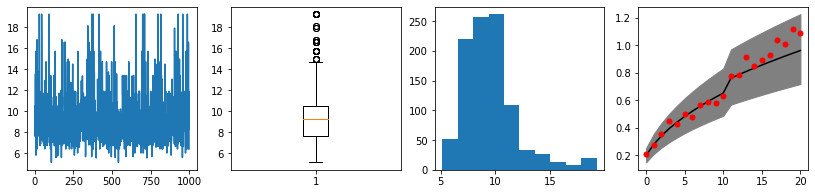

In [10]:
obsvar = np.maximum(0.2*Y, 0.1)

# Fit a calibrator with emulator 1
cal_1 = calibrator(emulator_1, Y, X_std, thetaprior = prior_balldrop, method = 'MLcal', yvar = obsvar, 
                   args = {'theta0': np.array([0.4]), 
                           'numsamp' : 1000, 
                           'stepType' : 'normal', 
                           'stepParam' : [0.6]})

plot_pred(X_std, Y, cal_1, theta_range)

n_acc rate= 0.178


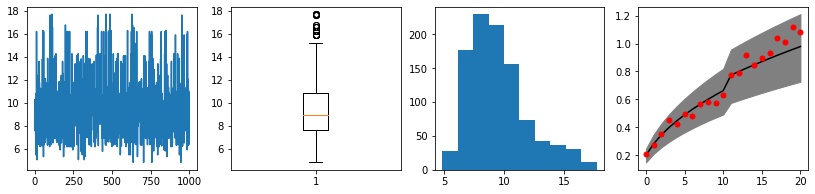

In [11]:
# Fit a calibrator with emulator 2
cal_2 = calibrator(emulator_2, Y, X_std, thetaprior = prior_balldrop, method = 'MLcal', yvar = obsvar, 
                   args = {'theta0': np.array([0.4]), 
                           'numsamp' : 1000, 
                           'stepType' : 'normal', 
                           'stepParam' : [0.6]})

plot_pred(X_std, Y, cal_2, theta_range)

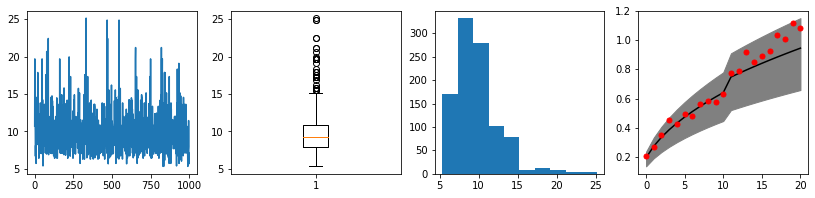

In [13]:
# Fit a calibrator with emulator 1 via plumlee sampler
cal_3 = calibrator(emulator_1, Y, X_std, thetaprior = prior_balldrop, method = 'MLcal', yvar = obsvar, 
                   args = {'method' : 'plumlee'})

plot_pred(X_std, Y, cal_3, theta_range)

## A new way of calibration: ML adjusted calibrator

### Filtering data

In [14]:
# Filter out the data
ys = 1 - np.sum((Y_model - Y)**2, 0)/np.sum((Y - np.mean(Y))**2, 0)
theta_f = theta[ys > 0.5]
print(theta_f.shape)

(33, 1)


In [15]:
# Obtain computer model output via filtered data
Y_model = timedrop(X_std, theta_f, height_range, theta_range)
print(np.shape(Y_model))

(21, 33)


### Fitting emulators via filtered data

In [16]:
# Fit an emulator via filtered data
emulator_f_1 = emulator(X_std, theta_f, Y_model, method = 'PCGPwM')

In [17]:
# Fit an emulator via filtered data
emulator_f_2 = emulator(X_std, theta_f, Y_model, method = 'PCGP_ozge', args = {'is_pca': True})

Function supplementtheta not found in module!
no of pcs: 2


### Comparing emulators

In [18]:
#Generate random reasonable theta values
theta_test = np.random.random(1000).reshape((1000, 1))
theta_test = theta_test[(theta_test > 0.2) & (theta_test < 0.5)]
theta_test = theta_test.reshape(len(theta_test), 1)
theta_range = np.array([1, 30])
print(np.shape(theta_test))

# Obtain computer model output
Y_model_test = timedrop(X_std, theta_test, height_range, theta_range)
print(np.shape(Y_model_test))

#Predict
p_1 = emulator_1.predict(X_std, theta_test)
p_1_mean = p_1.mean()
p_2 = emulator_2.predict(X_std, theta_test)
p_2_mean = p_2.mean()
p_f_1 = emulator_f_1.predict(X_std, theta_test)
p_f_1_mean = p_f_1.mean()
p_f_2 = emulator_f_2.predict(X_std, theta_test)
p_f_2_mean = p_2.mean()

(310, 1)
(21, 310)


In [19]:
print('SSE = ', np.sum((p_1_mean - Y_model_test)**2))
print('SSE = ', np.sum((p_2_mean - Y_model_test)**2))
print('SSE = ', np.sum((p_f_1_mean - Y_model_test)**2))
print('SSE = ', np.sum((p_f_2_mean - Y_model_test)**2))

print('Rsq = ', 1 - np.sum(np.square(p_1_mean - Y_model_test))/np.sum(np.square(Y_model_test.T - np.mean(Y_model_test, axis = 1))))
print('Rsq = ', 1 - np.sum(np.square(p_2_mean - Y_model_test))/np.sum(np.square(Y_model_test.T - np.mean(Y_model_test, axis = 1))))
print('Rsq = ', 1 - np.sum(np.square(p_f_1_mean - Y_model_test))/np.sum(np.square(Y_model_test.T - np.mean(Y_model_test, axis = 1))))
print('Rsq = ', 1 - np.sum(np.square(p_f_2_mean - Y_model_test))/np.sum(np.square(Y_model_test.T - np.mean(Y_model_test, axis = 1))))

SSE =  1.2848338291848934e-09
SSE =  2.4677054128133975e-06
SSE =  4.047692540903042e-06
SSE =  2.4677054128133975e-06
Rsq =  0.9999999999675034
Rsq =  0.9999999375857952
Rsq =  0.9999998976241209
Rsq =  0.9999999375857952


### Fitting a classifier

In [20]:
# Fit a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
Y_cls = np.zeros(len(theta))
Y_cls[ys > 0.5] = 1
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)#
clf.fit(theta, Y_cls)
print(clf.score(theta, Y_cls))
print(confusion_matrix(Y_cls, clf.predict(theta)))

1.0
[[67  0]
 [ 0 33]]


### Building a calibrator

n_acc rate= 0.133


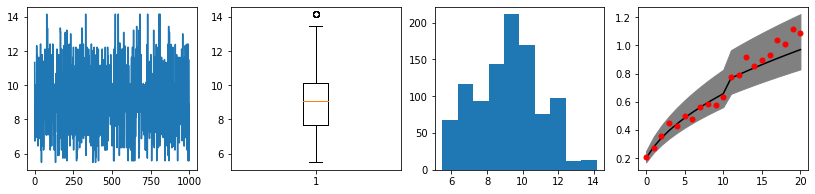

In [21]:
# Fit a calibrator with emulator 1 (filtered & ML)
cal_1_f = calibrator(emulator_f_1, Y, X_std, thetaprior = prior_balldrop, method = 'MLcal', yvar = obsvar, 
                   args = {'clf_method': clf,
                           'theta0': np.array([0.4]), 
                           'numsamp' : 1000, 
                           'stepType' : 'normal', 
                           'stepParam' : [0.6]})

plot_pred(X_std, Y, cal_1_f, theta_range)

n_acc rate= 0.173


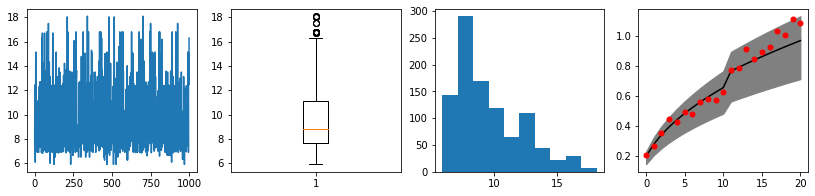

In [22]:
# Fit a calibrator with emulator 1 (filtered)
cal_2_f = calibrator(emulator_f_1, Y, X_std, thetaprior = prior_balldrop, method = 'MLcal', yvar = obsvar, 
                   args = {'theta0': np.array([0.4]), 
                           'numsamp' : 1000, 
                           'stepType' : 'normal', 
                           'stepParam' : [0.6]})

plot_pred(X_std, Y, cal_2_f, theta_range)